In [1]:
import numpy as np
import pandas as pd
import os
from nltk.stem.snowball import SnowballStemmer

import re
from sklearn.metrics import *
from sklearn.feature_extraction.text import *
from sklearn.model_selection import train_test_split
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import transformers
import nltk

nltk.download("stopwords")



%matplotlib inline
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Helen\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
stemmer = SnowballStemmer(language='english')
regex = re.compile("[A-Za-z]+")
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

stopwords=nltk.corpus.stopwords.words("english")
additional_words=["us", "always", "said", "then", "also", "usually", "would", "new", "last", "could", "year", "mr", "mrs","told", "say", "however", "may", "one", "two"]
stopwords+=additional_words


def words_only(text, regex=regex):
    try:
        return " ".join(regex.findall(text))
    except:
        return ""


def lemmatize(text, mystemmer=stemmer):
    try:
        tokens=[mystemmer.stem(token) for token in text.split()]
        return " ".join(tokens)
    except:
         return ""

def tokenize(text, mystopwords=stopwords):
    return [word for word in word_tokenize(text.lower()) if word not in mystopwords and len(word)>2]




In [3]:
#чтение данных

DATA_DIR ="../data/bbc/"

def get_dataset(DATA_DIR):
    data = []
    for file in [os.path.join(path, name) for path, subdirectory, files in os.walk(DATA_DIR) for name in files]:
        label = file.split("/")[3].split("\\")[0]
        content = " ".join(open(file, encoding='utf-8', errors='ignore').read().splitlines())
        data.append((content, label))
    return data


In [4]:
data=get_dataset(DATA_DIR)

In [5]:
data=pd.DataFrame(data, columns=['text', 'label'])

In [6]:
data

,text,label
0,Ad sales boost Time Warner profit Quarterly p...,business
1,Dollar gains on Greenspan speech The dollar h...,business
2,Yukos unit buyer faces loan claim The owners ...,business
3,High fuel prices hit BA's profits British Air...,business
4,Pernod takeover talk lifts Domecq Shares in U...,business
...,...,...
2160,Can Yahoo dominate next decade? Yahoo has rea...,tech
2161,Looks and music to drive mobiles Mobile phone...,tech
2162,Hotspot users gain free net calls People usin...,tech
2163,Domain system opens door to scams A system to...,tech


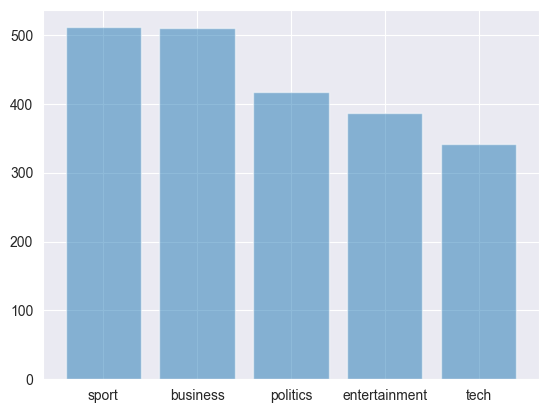

In [7]:
counts = data.label.value_counts()
values = counts.tolist()
labels = counts.index.tolist()

y_pos = np.arange(len(labels))

plt.bar(y_pos, values, align='center', alpha=0.5)
plt.xticks(y_pos, labels)
plt.show()

In [8]:
data.text=data.text.apply(words_only)

In [9]:
data.text=data.text.apply(lemmatize)

In [10]:
data.text=data.text.apply(tokenize)

In [21]:
data.text

0       [sale, boost, time, warner, profit, quarter, p...
1       [dollar, gain, greenspan, speech, dollar, hit,...
2       [yuko, unit, buyer, face, loan, claim, owner, ...
3       [high, fuel, price, hit, profit, british, airw...
4       [pernod, takeov, talk, lift, domecq, share, dr...
                              ...                        
2160    [yahoo, domin, next, decad, yahoo, reach, gran...
2161    [look, music, drive, mobil, mobil, phone, stil...
2162    [hotspot, user, gain, free, net, call, peopl, ...
2163    [domain, system, open, door, scam, system, mak...
2164    [soni, psp, tip, must, soni, playstat, portabl...
Name: text, Length: 2165, dtype: object

In [22]:
from gensim.models import Word2Vec

word_to_vec = Word2Vec(data.text, vector_size=100, window=5, min_count=5, workers=-1)

In [23]:
w2v = dict(zip(word_to_vec.wv.index_to_key, word_to_vec.wv.vectors))

In [24]:
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = len(word2vec.popitem()[1])
        # self.dim = len(word2vec.itervalues().next())

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

class TfidfEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.word2weight = None
        self.dim = len(word2vec.popitem()[1])
        # self.dim = len(word2vec.itervalues().next())

    def fit(self, X, y):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf,
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])

        return self

    def transform(self, X):
        return np.array([
                np.mean([self.word2vec[w] * self.word2weight[w]
                         for w in words if w in self.word2vec] or
                        [np.zeros(self.dim)], axis=0)
                for words in X
            ])

In [42]:
X = data.text.tolist()
y = data.label.tolist()

X, y = np.array(X), np.array(y)

X_train, X_rem, y_train, y_rem = train_test_split(X,y, train_size=0.70, shuffle=True, stratify=y)

#15% на тест и на валидацию
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5, shuffle=True, stratify=y_rem)

# Классический алгоритм

In [68]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import GridSearchCV

pipeline1 = Pipeline((
    ('vec', MeanEmbeddingVectorizer(w2v)),
    ('clf', RandomForestClassifier()),
    ))

pipeline2 = Pipeline((
    ('vec', MeanEmbeddingVectorizer(w2v)),
    ('clf', AdaBoostClassifier()),
    ))

pipeline3 = Pipeline((
     ('vec', TfidfEmbeddingVectorizer(w2v)),
    ('clf', RandomForestClassifier()),
    ))

pipeline4 = Pipeline((
     ('vec', TfidfEmbeddingVectorizer(w2v)),
    ('clf', AdaBoostClassifier()),
    ))

pips=[pipeline1, pipeline2, pipeline3, pipeline4]



parameters = {
    'clf__n_estimators':[1,10,100,1000]
  }


for pipe in pips:
    grid_pipeline = GridSearchCV(pipe ,parameters, cv=3, scoring="accuracy")
    grid_pipeline.fit(X_train,y_train)
    print("finished Gridsearch")
    print("clf: {}".format(pipe['clf']))
    print("vec: {}".format(pipe['vec']))
    print(grid_pipeline.best_params_)
    print(grid_pipeline.best_score_)



finished Gridsearch
clf: RandomForestClassifier()
vec: <__main__.MeanEmbeddingVectorizer object at 0x00000186E5531BB0>
{'clf__n_estimators': 1000}
0.7544554455445546
finished Gridsearch
clf: AdaBoostClassifier()
vec: <__main__.MeanEmbeddingVectorizer object at 0x00000186E5531C10>
{'clf__n_estimators': 1000}
0.6772277227722773
finished Gridsearch
clf: RandomForestClassifier()
vec: <__main__.TfidfEmbeddingVectorizer object at 0x00000186E5531460>
{'clf__n_estimators': 1000}
0.6877887788778878
finished Gridsearch
clf: AdaBoostClassifier()
vec: <__main__.TfidfEmbeddingVectorizer object at 0x00000186E5531220>
{'clf__n_estimators': 1000}
0.6118811881188119


In [70]:
clf_w2v = Pipeline([('vec', MeanEmbeddingVectorizer(w2v)),('clf', RandomForestClassifier(n_estimators=1000))])

In [71]:
clf_w2v.fit(X_train,y_train)
pred = clf_w2v.predict(X_test)

Precision:   0.80
Recall:   0.72
F1-measure:   0.74
Accuracy:   0.74
               precision    recall  f1-score   support

     business       0.66      0.84      0.74        76
entertainment       0.88      0.64      0.74        58
     politics       0.80      0.68      0.74        63
        sport       0.66      0.90      0.76        77
         tech       1.00      0.55      0.71        51

     accuracy                           0.74       325
    macro avg       0.80      0.72      0.74       325
 weighted avg       0.78      0.74      0.74       325



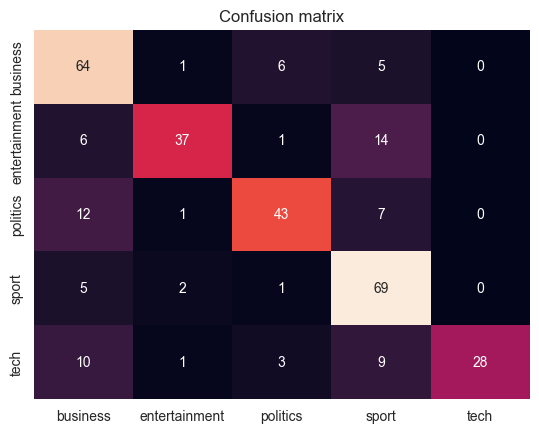

In [72]:
print("Precision: {0:6.2f}".format(precision_score(y_test, pred, average='macro')))
print("Recall: {0:6.2f}".format(recall_score(y_test, pred, average='macro')))
print("F1-measure: {0:6.2f}".format(f1_score(y_test, pred, average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(y_test, pred)))

print(classification_report(y_test, pred))

labels = clf_w2v.classes_

sns.heatmap(data=confusion_matrix(y_test, pred), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
plt.title("Confusion matrix")
plt.show()

Precision:   0.81
Recall:   0.76
F1-measure:   0.77
Accuracy:   0.78
               precision    recall  f1-score   support

     business       0.73      0.96      0.83        77
entertainment       0.77      0.59      0.67        58
     politics       0.89      0.63      0.74        62
        sport       0.72      0.90      0.80        77
         tech       0.92      0.71      0.80        51

     accuracy                           0.78       325
    macro avg       0.81      0.76      0.77       325
 weighted avg       0.79      0.78      0.77       325



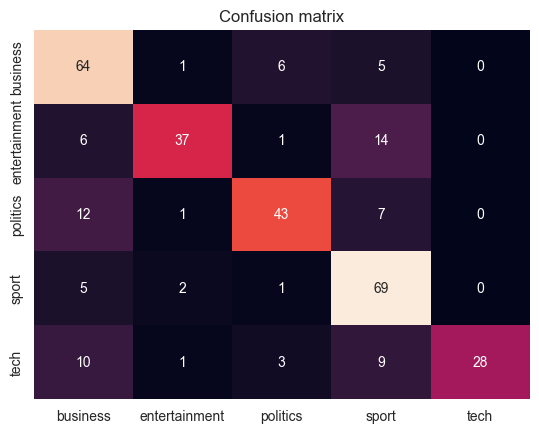

In [73]:
#проверка на инференсе
pred_valid=clf_w2v.predict(X_valid)

print("Precision: {0:6.2f}".format(precision_score(y_valid, pred_valid, average='macro')))
print("Recall: {0:6.2f}".format(recall_score(y_valid, pred_valid, average='macro')))
print("F1-measure: {0:6.2f}".format(f1_score(y_valid, pred_valid, average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(y_valid, pred_valid)))

print(classification_report(y_valid, pred_valid))

labels = clf_w2v.classes_

sns.heatmap(data=confusion_matrix(y_test, pred), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
plt.title("Confusion matrix")
plt.show()

# Часть 2. Модель DistillBERT

In [52]:
data=get_dataset(DATA_DIR)
data=pd.DataFrame(data, columns=['text', 'label'])

In [34]:
id2label=dict({i: val for i, val in enumerate(labels)})
label2id=dict({val: i for i, val in enumerate(labels)})

In [50]:
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
model_path_or_name = "distilbert-base-uncased"
tokenizer = DistilBertTokenizerFast.from_pretrained(model_path_or_name)
model = DistilBertForSequenceClassification.from_pretrained(model_path_or_name, num_labels=5, id2label=id2label, label2id=label2id)



loading file vocab.txt from cache at C:\Users\Helen/.cache\huggingface\hub\models--distilbert-base-uncased\snapshots\043235d6088ecd3dd5fb5ca3592b6913fd516027\vocab.txt
loading file tokenizer.json from cache at C:\Users\Helen/.cache\huggingface\hub\models--distilbert-base-uncased\snapshots\043235d6088ecd3dd5fb5ca3592b6913fd516027\tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at C:\Users\Helen/.cache\huggingface\hub\models--distilbert-base-uncased\snapshots\043235d6088ecd3dd5fb5ca3592b6913fd516027\tokenizer_config.json
loading configuration file config.json from cache at C:\Users\Helen/.cache\huggingface\hub\models--distilbert-base-uncased\snapshots\043235d6088ecd3dd5fb5ca3592b6913fd516027\config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_d

In [53]:
data['label'] = data['label'].apply(lambda x: label2id[x])

In [54]:
data.head()

,text,label
0,Ad sales boost Time Warner profit Quarterly p...,1
1,Dollar gains on Greenspan speech The dollar h...,1
2,Yukos unit buyer faces loan claim The owners ...,1
3,High fuel prices hit BA's profits British Air...,1
4,Pernod takeover talk lifts Domecq Shares in U...,1


In [55]:
#разобьем данные на трейн, тест и валидацию и сохраним их в отдельных csv файлах

data_train, data_rem = train_test_split(data, train_size=0.7, shuffle=True, stratify=data['label'])

data_test, data_val=train_test_split(data_rem, test_size=0.5, shuffle=True, stratify=data_rem['label'] )

#сохраним данные в csv файле чтобы далее использовать в load_datasets
data_train.to_csv("../data/bbc_outputs/bbc_train.csv", index=False, encoding='utf-8')
data_test.to_csv("../data/bbc_outputs/bbc_test.csv", index=False, encoding='utf-8')
data_val.to_csv("../data/bbc_outputs/bbc_val.csv", index=False, encoding='utf-8')

In [56]:
from datasets import load_dataset
bbc_data=load_dataset('csv', data_files={'train':['../data/bbc_outputs/bbc_train.csv'],
        'test':['../data/bbc_outputs/bbc_test.csv'], 'val':['../data/bbc_outputs/bbc_val.csv']})

Using custom data configuration default-af4698ec5cb28a16


Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to C:/Users/Helen/.cache/huggingface/datasets/csv/default-af4698ec5cb28a16/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [57]:
bbc_test=bbc_data['test']
bbc_train=bbc_data['train']
bbc_val=bbc_data['val']

In [58]:
enc_train = bbc_train.map(lambda e: tokenizer( e['text'], padding=True, truncation=True, max_length=512),batched=True, batch_size=100)
enc_test =  bbc_test.map(lambda e: tokenizer( e['text'], padding=True, truncation=True, max_length=512),batched=True, batch_size=100)
enc_val =   bbc_val.map(lambda e: tokenizer( e['text'], padding=True, truncation=True, max_length=512),batched=True, batch_size=100)

  0%|          | 0/16 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

In [59]:
from transformers import TrainingArguments, Trainer
import torch
training_args = TrainingArguments(
    output_dir='../data/bbc_outputs/MyBBCModel',
    do_train=True,
    do_eval=True,
    num_train_epochs=3,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    warmup_steps=100,
    weight_decay=0.01,
    logging_strategy='steps',
    logging_dir='../data/bbc_outputs/logs',
    logging_steps=200,
    evaluation_strategy= 'steps',
    fp16= torch.cuda.is_available()
)

using `logging_steps` to initialize `eval_steps` to 200
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [103]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    Precision, Recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    return {
        'Accuracy': acc,
        'F1': f1,
        'Precision': Precision,
        'Recall': Recall
    }

def compute_metrics_per_label(pred):
    labels=pred.label_ids
    preds=pred.predictions.argmax(-1)

    acc_wall=[]
    f1_wall=[]
    prec_wall=[]
    recall_wall=[]

    for label in np.unique(labels):
        y_preds = preds[labels==label]
        y_true = labels[labels==label]
        y_preds[y_preds!=label]=0 #маска для значений, не равных label
        acc_wall.append(accuracy_score(y_true, y_preds))
        f1_wall.append(f1_score(y_true, y_preds, average="binary", pos_label=label))
        prec_wall.append(precision_score(y_true, y_preds, average="binary", pos_label=label))
        recall_wall.append(recall_score(y_true, y_preds, average="binary", pos_label=label))
    return {
        'Accuracy': acc_wall,
        'F1': f1_wall,
        'Precision': prec_wall,
        'Recall': recall_wall
    }


In [64]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=enc_train,
    eval_dataset=enc_val,
    compute_metrics= compute_metrics
)

In [65]:
results=trainer.train()

The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 1515
  Num Epochs = 3
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 144


Step,Training Loss,Validation Loss




Training completed. Do not forget to share your model on huggingface.co/models =)




In [66]:
model_save_path = "../data/bbc_outputs/MyBBCModel"
trainer.save_model(model_save_path)
tokenizer.save_pretrained(model_save_path)

Saving model checkpoint to ../data/bbc_outputs/MyBBCModel
Configuration saved in ../data/bbc_outputs/MyBBCModel\config.json
Model weights saved in ../data/bbc_outputs/MyBBCModel\pytorch_model.bin
tokenizer config file saved in ../data/bbc_outputs/MyBBCModel\tokenizer_config.json
Special tokens file saved in ../data/bbc_outputs/MyBBCModel\special_tokens_map.json


('../data/bbc_outputs/MyBBCModel\\tokenizer_config.json',
 '../data/bbc_outputs/MyBBCModel\\special_tokens_map.json',
 '../data/bbc_outputs/MyBBCModel\\vocab.txt',
 '../data/bbc_outputs/MyBBCModel\\added_tokens.json',
 '../data/bbc_outputs/MyBBCModel\\tokenizer.json')

In [ ]:
#метрики по всем множествам
q=[trainer.evaluate(eval_dataset=data) for data in [enc_train, enc_val, enc_test]]
pd.DataFrame(q, index=labels).iloc[:,:5]

In [70]:
pd.DataFrame(q, index=["train","val","test"]).iloc[:,:5]

,eval_loss,eval_Accuracy,eval_F1,eval_Precision,eval_Recall
train,0.042930,0.991419,0.991494,0.991229,0.991859
val,0.041288,0.990769,0.990959,0.990000,0.992139
test,0.041636,0.990769,0.991302,0.990769,0.992208


In [105]:
#проверка на тесте по классу
pred = trainer.predict(enc_test)
q=compute_metrics_per_label(pred)
pd.DataFrame(q, index=labels).iloc[:,:5]

The following columns in the test set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 325
  Batch size = 64


,Accuracy,F1,Precision,Recall
sport,1.000000,1.000000,1.0,1.000000
business,0.961039,0.980132,1.0,0.961039
politics,1.000000,1.000000,1.0,1.000000
entertainment,1.000000,1.000000,1.0,1.000000
tech,1.000000,1.000000,1.0,1.000000


In [104]:
#проверка на инференсе по классу
pred = trainer.predict(enc_val)
q=compute_metrics_per_label(pred)
pd.DataFrame(q, index=labels).iloc[:,:5]

The following columns in the test set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 325
  Batch size = 64


,Accuracy,F1,Precision,Recall
sport,1.000000,1.000000,1.0,1.000000
business,0.973684,0.986667,1.0,0.973684
politics,1.000000,1.000000,1.0,1.000000
entertainment,1.000000,1.000000,1.0,1.000000
tech,1.000000,1.000000,1.0,1.000000


In [106]:
#возьмем текст с политики
text="""Tony Blair lied when he took the UK to war so has no qualms about lying in the election campaign, say the Tories.

Tory co-chairman Liam Fox was speaking after Mr Blair told Labour members the Tories offered a "hard right agenda". Dr Fox told BBC Radio: "If you are willing to lie about the reasons for going to war, I guess you are going to lie about anything at all." He would not discuss reports the party repaid £500,000 to Lord Ashcroft after he predicted an election defeat.

The prime minister ratcheted up Labour's pre-election campaigning at the weekend with a helicopter tour of the country and his speech at the party's spring conference. He insisted he did not know the poll date, but it is widely expected to be 5 May"""

In [107]:
def predict(text):
    inputs = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors="pt")
    outputs = model(**inputs)
    probs = outputs.logits.softmax(1)
    return probs, probs.argmax(-1), model.config.id2label[probs.argmax(-1).item()]

In [108]:
predict(text)

(tensor([[0.0020, 0.0028, 0.9909, 0.0021, 0.0021]], grad_fn=<SoftmaxBackward0>),
 tensor([2]),
 'politics')

# Вывод
Для данной задачи классификации лучшие метрики по целому корпусу и по каждому отдельному классу оказались у второй модели DistilBert.